# Block vs non-block, normalisation vs non-normalisation - One Dimensional analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dwidth = 512

In [3]:
#noiselevel = 0.002
noiselevel = 0.005

In [4]:
#Create data

x= np.arange(dwidth,dtype=np.float32)
data=np.zeros_like(x)

#circular bumps
#bumps (pos, radius)
xbumps = [ (150,20) , (200,10), (300,30), (315,10)]

for xpos,r in xbumps:
    data+= np.sqrt( np.where( np.abs(x-xpos) < r, 1, 0) * (r**2 - (x-xpos)**2 ) )/r

#rectangular bumps
#(xstart, xend, height)
xrectbumps = [ (110,115), (250,252) , (350,400)]
for x0, x1 in xrectbumps:
    data+= np.where( x<x1, 1,0)* np.where(x>=x0,1,0)

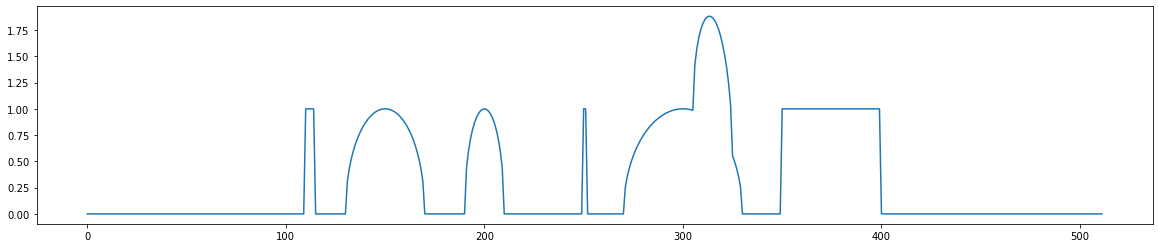

In [5]:
plt.figure(figsize=(20,4))
plt.plot(x,data)

## PSF

In [6]:
#convolute with a 3D gaussian centered at (0,0,0)
w_psf = 16
w_psf_half = int(w_psf/2)

x_psf = np.linspace(-w_psf_half, + w_psf_half,w_psf)
gauss1d = np.exp( np.multiply(x_psf,x_psf)/ -8 )

In [7]:
x_psf.shape

(16,)

In [8]:
# Normalise to sum
psf_norm = gauss1d / gauss1d.sum()

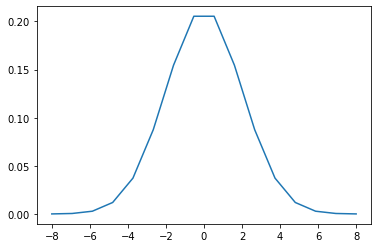

In [9]:
plt.plot(x_psf,psf_norm)

In [10]:
#Circulify psf
psf_norm0 = np.roll(psf_norm, int(psf_norm.shape[0]/2) )

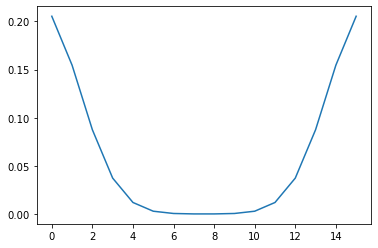

In [11]:
plt.plot(psf_norm0)

Convolve data

In [12]:
from scipy import signal
#Convolute data with gaussian
data_psfconv = signal.convolve(data, psf_norm , mode = 'full') # I believe that this already takes into account that psf is not centered
#data_psfconv = signal.convolve(data, psf_norm0 , mode = 'full') # Gives strange results

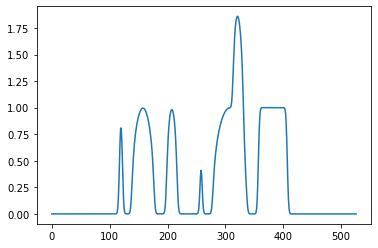

In [13]:
plt.plot(data_psfconv) #note that the result shifted

In [14]:
# Add noise
#Use poisson noise
#https://numpy.org/doc/stable/reference/random/index.html#random-quick-start
from numpy.random import default_rng
rng = default_rng()

noise3d = rng.poisson(lam=25, size=data_psfconv.shape)

data3dconvnoise = data_psfconv + noise3d*data_psfconv.max()*noiselevel

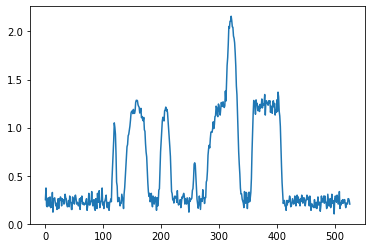

In [15]:
plt.plot(data3dconvnoise)

Create a cropped region

In [16]:
x_crop_0, x_crop_1 = 100 , 350
data_crop = data3dconvnoise[x_crop_0:x_crop_1]

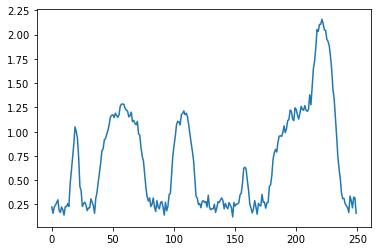

In [17]:
plt.plot(data_crop)

## RL convolution from skimage.restoration, no normalisation, no padding

In [18]:
niter=21

In [19]:
import skimage.restoration
deconv_skimageRL = skimage.restoration.richardson_lucy(data3dconvnoise,psf_norm, niter, clip=False)

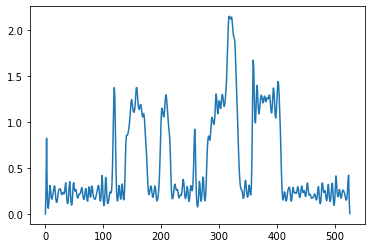

In [20]:
plt.plot(deconv_skimageRL)

Calculate RL in cropped section of data

In [21]:
deconv_skimageRL_crop = skimage.restoration.richardson_lucy(data_crop,psf_norm, niter, clip=False)

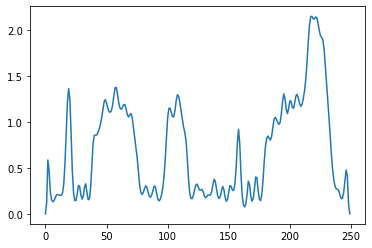

In [22]:
plt.plot(deconv_skimageRL_crop)

Compare results

In [23]:
diffsq = np.power(deconv_skimageRL_crop-deconv_skimageRL[x_crop_0:x_crop_1 ], 2)

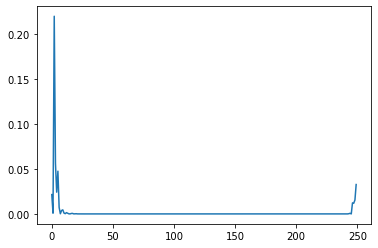

In [24]:
plt.plot(diffsq)

In [25]:
diffsq_valid = diffsq < 1e-12

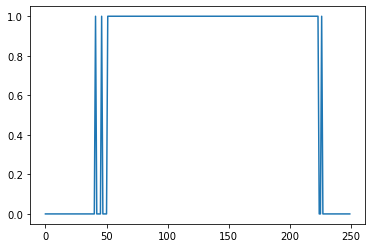

In [26]:
plt.plot(diffsq_valid)

In [27]:
#Get maximum width
def get_max_width(data1d, valcond = 1):
    maxwidth0=0
    width0=0
    for i in range(data1d.shape[0]):
        v0 = data1d[i]
        if v0==valcond:
            width0+=1
        else:
            width0==0
        maxwidth0 = max(maxwidth0,width0)
    return maxwidth0

In [28]:
get_max_width(diffsq_valid)

176

For this RL calculation and croping , try to get max_width of the valid cropped region as a function of number of iterations used in RL

In [29]:
def crop_vs_noncrop_RL_diff_get_valid_max_width(niter0=20):
    print( data3dconvnoise.shape)
    deconv_skimageRL = skimage.restoration.richardson_lucy(data3dconvnoise,psf_norm, niter0, clip=False)
    deconv_skimageRL_crop = skimage.restoration.richardson_lucy(data_crop,psf_norm, niter0, clip=False)
    diffsq = np.power(deconv_skimageRL_crop-deconv_skimageRL[x_crop_0:x_crop_1 ], 2)
    diffsq_valid0 = diffsq < 1e-12
    m0 = get_max_width(diffsq_valid0)
    return m0

In [30]:
#test
crop_vs_noncrop_RL_diff_get_valid_max_width(19)

(527,)


175

In [31]:
niter_range = np.arange(2,100)
maxwidths = []
for niter0 in niter_range:
    maxwidth = crop_vs_noncrop_RL_diff_get_valid_max_width(niter0)
    print("niter0: ", niter0 , ", maxwidth:", maxwidth)
    maxwidths.append( (niter0,maxwidth) )

(527,)
niter0:  2 , maxwidth: 216
(527,)
niter0:  3 , maxwidth: 208
(527,)
niter0:  4 , maxwidth: 206
(527,)
niter0:  5 , maxwidth: 200
(527,)
niter0:  6 , maxwidth: 199
(527,)
niter0:  7 , maxwidth: 197
(527,)
niter0:  8 , maxwidth: 194
(527,)
niter0:  9 , maxwidth: 192
(527,)
niter0:  10 , maxwidth: 189
(527,)
niter0:  11 , maxwidth: 188
(527,)
niter0:  12 , maxwidth: 185
(527,)
niter0:  13 , maxwidth: 186
(527,)
niter0:  14 , maxwidth: 182
(527,)
niter0:  15 , maxwidth: 180
(527,)
niter0:  16 , maxwidth: 179
(527,)
niter0:  17 , maxwidth: 179
(527,)
niter0:  18 , maxwidth: 179
(527,)
niter0:  19 , maxwidth: 175
(527,)
niter0:  20 , maxwidth: 174
(527,)
niter0:  21 , maxwidth: 176
(527,)
niter0:  22 , maxwidth: 172
(527,)
niter0:  23 , maxwidth: 172
(527,)
niter0:  24 , maxwidth: 170
(527,)
niter0:  25 , maxwidth: 170
(527,)
niter0:  26 , maxwidth: 169
(527,)
niter0:  27 , maxwidth: 169
(527,)
niter0:  28 , maxwidth: 167
(527,)
niter0:  29 , maxwidth: 167
(527,)
niter0:  30 , maxwidt

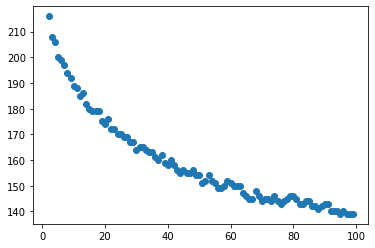

In [32]:
plt.scatter(*zip(*maxwidths))

Plot shows that valid region in a cropped block after the RL deconvolution drops with the number of RL iterations in an exponential way.

When doing block deconvolution, this may need to be taken into account.

It remains to see how the psf size also affects the padding region needed to be considered

## Get maxwidth as a function of number of iterations and psf size

In [33]:
def crop_vs_noncrop_RL_diff_get_valid_max_width_vs_iter_and_psfsize(niter0=20, psf_half_width0=8):
    #print(niter, psf_half_width0)
    #print(data.shape)

    #convolute with a 3D gaussian centered at (0,0,0)
    psf_width0 = 2*psf_half_width0

    x_psf0 = np.linspace(-psf_half_width0, + psf_half_width0,psf_width0)
    gauss1d0 = np.exp( -np.multiply(x_psf0,x_psf0) / psf_half_width0 )
    psf_norm0 = gauss1d0 / gauss1d0.sum()

    data_psfconv0 = signal.convolve(data, psf_norm0 , mode = 'full') # I believe that this already takes into account that psf is not centered
    
    #Add noise
    rng = default_rng()
    noise3d = rng.poisson(lam=25, size=data_psfconv0.shape)
    data3dconvnoise0 = data_psfconv0 + noise3d*data_psfconv0.max()*0.002

    x_crop_0, x_crop_1 = 100 , 350
    data_crop0 = data3dconvnoise0[x_crop_0:x_crop_1]

    deconv_skimageRL0 = skimage.restoration.richardson_lucy(data3dconvnoise0,psf_norm0, niter0, clip=False)
    deconv_skimageRL_crop0 = skimage.restoration.richardson_lucy(data_crop0,psf_norm0, niter0, clip=False)

    diffsq0 = np.power( deconv_skimageRL_crop0 - deconv_skimageRL0[x_crop_0:x_crop_1 ], 2)
    diffsq_valid0 = diffsq0 < 1e-12
    m0 = get_max_width(diffsq_valid0)
    return m0

In [34]:
#test
crop_vs_noncrop_RL_diff_get_valid_max_width_vs_iter_and_psfsize()

179

In [35]:
niter_range = np.arange(2,100)
psf_hwidth_range = np.arange(8,32)

maxwidths_vs_niter_and_psfhwidth = []
for niter0 in niter_range:
    for phw0 in psf_hwidth_range:
        maxwidth = crop_vs_noncrop_RL_diff_get_valid_max_width_vs_iter_and_psfsize(niter0, phw0)
        print("niter0: ", niter0 , ", maxwidth:", maxwidth, "psf_width:", phw0)
        maxwidths_vs_niter_and_psfhwidth.append( (niter0,maxwidth,phw0) )

niter0:  2 , maxwidth: 217 psf_width: 8
niter0:  2 , maxwidth: 215 psf_width: 9
niter0:  2 , maxwidth: 213 psf_width: 10
niter0:  2 , maxwidth: 211 psf_width: 11
niter0:  2 , maxwidth: 209 psf_width: 12
niter0:  2 , maxwidth: 206 psf_width: 13
niter0:  2 , maxwidth: 204 psf_width: 14
niter0:  2 , maxwidth: 203 psf_width: 15
niter0:  2 , maxwidth: 200 psf_width: 16
niter0:  2 , maxwidth: 199 psf_width: 17
niter0:  2 , maxwidth: 197 psf_width: 18
niter0:  2 , maxwidth: 195 psf_width: 19
niter0:  2 , maxwidth: 193 psf_width: 20
niter0:  2 , maxwidth: 192 psf_width: 21
niter0:  2 , maxwidth: 190 psf_width: 22
niter0:  2 , maxwidth: 189 psf_width: 23
niter0:  2 , maxwidth: 187 psf_width: 24
niter0:  2 , maxwidth: 186 psf_width: 25
niter0:  2 , maxwidth: 185 psf_width: 26
niter0:  2 , maxwidth: 183 psf_width: 27
niter0:  2 , maxwidth: 182 psf_width: 28
niter0:  2 , maxwidth: 181 psf_width: 29
niter0:  2 , maxwidth: 179 psf_width: 30
niter0:  2 , maxwidth: 179 psf_width: 31
niter0:  3 , maxwi

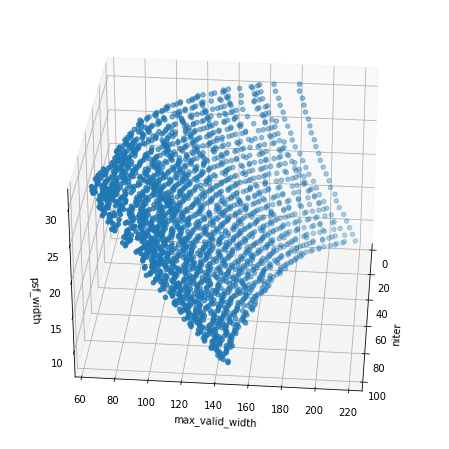

In [36]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d', )
ax.scatter(*zip(*maxwidths_vs_niter_and_psfhwidth))
ax.set_xlabel('niter')
ax.set_ylabel('max_valid_width')
ax.set_zlabel('psf_width')
ax.view_init(azim=5)
plt.show()

Increasing PSF width makes valid_width reduce significantly in an apparent linear fashion

In [37]:
psf_hwidth_range = np.arange(8,32)

maxwidths_vs_psfwidth = []
niter0=20 #Fixed number of RL iterations

for phw0 in psf_hwidth_range:
    maxwidth = crop_vs_noncrop_RL_diff_get_valid_max_width_vs_iter_and_psfsize(niter0, phw0)
    print("psf_width: ", phw0 , ", maxwidth:", maxwidth, )
    maxwidths_vs_psfwidth.append( (phw0,maxwidth) )

psf_width:  8 , maxwidth: 176
psf_width:  9 , maxwidth: 176
psf_width:  10 , maxwidth: 168
psf_width:  11 , maxwidth: 167
psf_width:  12 , maxwidth: 163
psf_width:  13 , maxwidth: 160
psf_width:  14 , maxwidth: 155
psf_width:  15 , maxwidth: 154
psf_width:  16 , maxwidth: 148
psf_width:  17 , maxwidth: 149
psf_width:  18 , maxwidth: 146
psf_width:  19 , maxwidth: 142
psf_width:  20 , maxwidth: 138
psf_width:  21 , maxwidth: 136
psf_width:  22 , maxwidth: 135
psf_width:  23 , maxwidth: 131
psf_width:  24 , maxwidth: 127
psf_width:  25 , maxwidth: 125
psf_width:  26 , maxwidth: 124
psf_width:  27 , maxwidth: 124
psf_width:  28 , maxwidth: 119
psf_width:  29 , maxwidth: 117
psf_width:  30 , maxwidth: 114
psf_width:  31 , maxwidth: 113


Text(0, 0.5, 'max valid width')

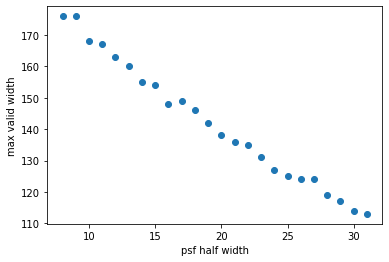

In [38]:
plt.scatter(*zip(*maxwidths_vs_psfwidth))
#plt.axline(*zip(*maxwidths_vs_psfwidth))
plt.xlabel("psf half width")
plt.ylabel("max valid width")

Confirmation that maximum valid width decreases linearly as the psf size increases.

Try to fit a line and get the parameters

In [39]:
maxwidths_vs_psfwidth_np = np.array(maxwidths_vs_psfwidth)
maxwidths = maxwidths_vs_psfwidth_np[:,1]
psfhwidth = maxwidths_vs_psfwidth_np[:,0]

In [40]:
fitparams = np.polyfit(maxwidths, 2*psfhwidth, 1)
fitparams

array([ -0.71301281, 140.21811008])

Interesting, the maxwidth does not reduce by a -1.0*psfwidth .

TODO: Try to do RL using a different method (non-skimage) with and without normalisation and see how that affects the valid width